In [1]:
import keras
from keras.datasets import mnist
from keras.models import model_from_json
from keras.utils import np_utils
from keras.optimizers import RMSprop

from keras import backend as K

import numpy as np
import matplotlib.pyplot as plt

Using TensorFlow backend.


In [2]:
def generate_grads(x, label, model):
    class_output = model.output[:, int(label)]
    
    grads = K.gradients(class_output, model.input)[0]
    gradient_function = K.function([model.input], [grads])

    grads_val = gradient_function([x.reshape(1, 784)])
    
    return np.array(grads_val).reshape(784)

In [3]:
def generate_adv(x, label, model, eps):
    p = np.sign(generate_grads(x, label, model))
    
#     plt.imshow(p.reshape(28,28), 'gray')
#     plt.show()
    
    adv = (x - eps*p).clip(min=0, max=1).reshape(784)
    
    return adv

In [4]:
def predict(x, model):
    pred = model.predict(x.reshape(1,784), batch_size=1)
    pred_class = np.argmax(pred)
    pred_per = max(pred[0])
    
    return pred_class, pred_per

In [5]:
def generate_pareto_adv(x, label, model, eps, per):
    g = generate_grads(x, label, model)
    abs_g = np.abs(g).reshape(784)
    
#     plt.hist(abs_g)
#     plt.show()
#     plt.cla()
    
    idxs_abs_g = np.argsort(abs_g)[::-1][:int(784*per)]
    
    pareto_p = np.zeros(784)
    for idx in idxs_abs_g:
        pareto_p[idx] = g[idx]
        
#     plt.imshow(np.sign(pareto_p).reshape(28,28), 'gray')
#     plt.show()

    pareto_adv = (x - eps*np.sign(pareto_p)).clip(min=0, max=1).reshape(784)
    
    return pareto_adv

In [6]:
eps = 0.4
per = 0.05

In [7]:
num_classes = 10

In [8]:
(X_train, y_train), (X_test, y_test) = mnist.load_data()

X_train = X_train.reshape(60000, 784).astype('float32') / 255
X_test  = X_test.reshape(10000, 784).astype('float32') / 255

print(X_train.shape[0], 'train samples')
print(X_test.shape[0], 'test samples')

y_train_catego = keras.utils.to_categorical(y_train, num_classes)
y_test_catego = keras.utils.to_categorical(y_test, num_classes)

60000 train samples
10000 test samples


In [9]:
# モデルを読み込む
model = model_from_json(open('mnist_mlp_model.json').read())

# 学習結果を読み込む
model.load_weights('mnist_mlp_weights.h5')

model.summary()

model.compile(loss='categorical_crossentropy',
              optimizer=RMSprop(),
              metrics=['accuracy'])

W0111 16:12:25.402154 140736235160512 deprecation_wrapper.py:119] From /Users/ryuto/anaconda3/lib/python3.7/site-packages/keras/backend/tensorflow_backend.py:517: The name tf.placeholder is deprecated. Please use tf.compat.v1.placeholder instead.

W0111 16:12:25.423469 140736235160512 deprecation_wrapper.py:119] From /Users/ryuto/anaconda3/lib/python3.7/site-packages/keras/backend/tensorflow_backend.py:4138: The name tf.random_uniform is deprecated. Please use tf.random.uniform instead.

W0111 16:12:25.444493 140736235160512 deprecation_wrapper.py:119] From /Users/ryuto/anaconda3/lib/python3.7/site-packages/keras/backend/tensorflow_backend.py:131: The name tf.get_default_graph is deprecated. Please use tf.compat.v1.get_default_graph instead.

W0111 16:12:25.445580 140736235160512 deprecation_wrapper.py:119] From /Users/ryuto/anaconda3/lib/python3.7/site-packages/keras/backend/tensorflow_backend.py:133: The name tf.placeholder_with_default is deprecated. Please use tf.compat.v1.placehol

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_1 (Dense)              (None, 512)               401920    
_________________________________________________________________
dropout_1 (Dropout)          (None, 512)               0         
_________________________________________________________________
dense_2 (Dense)              (None, 512)               262656    
_________________________________________________________________
dropout_2 (Dropout)          (None, 512)               0         
_________________________________________________________________
dense_3 (Dense)              (None, 10)                5130      
Total params: 669,706
Trainable params: 669,706
Non-trainable params: 0
_________________________________________________________________


In [10]:
score = model.evaluate(X_test, y_test_catego, verbose=0)
print('Test loss :', score[0])
print('Test accuracy :', score[1])

Test loss : 0.10931812194355357
Test accuracy : 0.9842


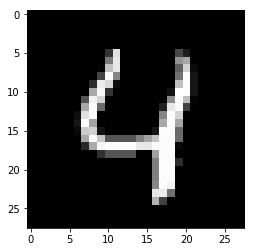

In [11]:
idx = 4
x = X_test[idx]
y = y_test[idx]
plt.imshow(x.reshape(28,28), 'gray')
plt.show()

In [12]:
pred_class, pred_per = predict(x, model)
print(pred_class, pred_per)

4 0.99999833


(784,)


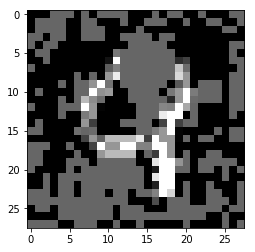

In [13]:
adv = generate_adv(x, y, model, eps)
print(adv.shape)
plt.imshow(adv.reshape(28,28), 'gray')
plt.show()

In [14]:
pred_class, pred_per = predict(adv, model)
print(pred_class, pred_per)

3 0.7810815


(784,)


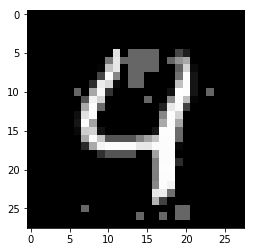

In [15]:
p_adv = generate_pareto_adv(x, y, model, eps, per)
print(p_adv.shape)
plt.imshow(p_adv.reshape(28,28), 'gray')
plt.show()

In [16]:
pred_class, pred_per = predict(p_adv, model)
print(pred_class, pred_per)

9 1.0


In [17]:
def generate_adv_list(x_list, y_list, model, eps):
    adv_list = []
    
    for x, y in zip(x_list, y_list):
        adv = generate_adv(x, y, model, eps).reshape(784)
        adv_list.append(adv)
        
    return np.array(adv_list)

In [18]:
def generate_pareto_adv_list(x_list, y_list, model, eps, per):
    pareto_adv_list = []
    
    for x, y in zip(x_list, y_list):
        pareto_adv = generate_pareto_adv(x, y, model, eps, per).reshape(784)
        pareto_adv_list.append(pareto_adv)
        
    return np.array(pareto_adv_list)

In [19]:
max_n = 100

In [20]:
adv_test = generate_adv_list(X_test[:max_n], y_test[:max_n], model, eps)
adv_test.shape

(100, 784)

In [21]:
pareto_adv_test = generate_pareto_adv_list(X_test[:max_n], y_test[:max_n], model, eps, per)
pareto_adv_test.shape

(100, 784)

In [22]:
score = model.evaluate(adv_test, y_test_catego[:max_n], verbose=0)
print('Test loss :', score[0])
print('Test accuracy :', score[1])

Test loss : 15.934911193847656
Test accuracy : 0.0


In [23]:
score = model.evaluate(X_test[:max_n], y_test_catego[:max_n], verbose=0)
print('Test loss :', score[0])
print('Test accuracy :', score[1])

Test loss : 4.2783838143805045e-05
Test accuracy : 1.0


In [24]:
score = model.evaluate(pareto_adv_test[:max_n], y_test_catego[:max_n], verbose=0)
print('Test loss :', score[0])
print('Test accuracy :', score[1])

Test loss : 3.6209060192108153
Test accuracy : 0.6
